In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
import regex as re

In [59]:
df = pd.read_csv("side_dataset.csv")
df.head()

,Posted On,BHK,Rent,Size,Floor,Area Type,Area Locality,City,Furnishing Status,Tenant Preferred,Bathroom,Point of Contact
0,2022-05-18,2,10000,1100,Ground out of 2,Super Area,Bandel,Kolkata,Unfurnished,Bachelors/Family,2,Contact Owner
1,2022-05-13,2,20000,800,1 out of 3,Super Area,"Phool Bagan, Kankurgachi",Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner
2,2022-05-16,2,17000,1000,1 out of 3,Super Area,Salt Lake City Sector 2,Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner
3,2022-07-04,2,10000,800,1 out of 2,Super Area,Dumdum Park,Kolkata,Unfurnished,Bachelors/Family,1,Contact Owner
4,2022-05-09,2,7500,850,1 out of 2,Carpet Area,South Dum Dum,Kolkata,Unfurnished,Bachelors,1,Contact Owner


In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4746 entries, 0 to 4745
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Posted On          4746 non-null   object
 1   BHK                4746 non-null   int64 
 2   Rent               4746 non-null   int64 
 3   Size               4746 non-null   int64 
 4   Floor              4746 non-null   object
 5   Area Type          4746 non-null   object
 6   Area Locality      4746 non-null   object
 7   City               4746 non-null   object
 8   Furnishing Status  4746 non-null   object
 9   Tenant Preferred   4746 non-null   object
 10  Bathroom           4746 non-null   int64 
 11  Point of Contact   4746 non-null   object
dtypes: int64(4), object(8)
memory usage: 445.1+ KB


In [61]:
df.isna().sum()

Posted On            0
BHK                  0
Rent                 0
Size                 0
Floor                0
Area Type            0
Area Locality        0
City                 0
Furnishing Status    0
Tenant Preferred     0
Bathroom             0
Point of Contact     0
dtype: int64

In [62]:
pd.to_datetime(df["Posted On"]).describe()

count                             4746
mean     2022-06-07 18:01:40.126422272
min                2022-04-13 00:00:00
25%                2022-05-20 00:00:00
50%                2022-06-10 00:00:00
75%                2022-06-28 00:00:00
max                2022-07-11 00:00:00
Name: Posted On, dtype: object

- there are no nulls in the data but we still need to look for outliers
- however I will start by reducing the dataset by collecting the common features in both datasets

## Reducing the Dataset Features

In [63]:
df = df.drop(columns=["Posted On", "Floor", "Area Type", "Area Locality", "City", "Tenant Preferred", "Point of Contact"])

In [64]:
df.head()

,BHK,Rent,Size,Furnishing Status,Bathroom
0,2,10000,1100,Unfurnished,2
1,2,20000,800,Semi-Furnished,1
2,2,17000,1000,Semi-Furnished,1
3,2,10000,800,Unfurnished,1
4,2,7500,850,Unfurnished,1


corresponding features to main dataset
- BHK: number of bedrooms, halls and kitchen -> beds
- Rent -> price
- Size -> sqfeet
- Furnishing Status -> comes_furnished
- Bathroom -> baths

In [65]:
# chaging the column names
df = df.rename(columns={"BHK":"beds",
                        "Rent":"price",
                        "Size":"sqfeet",
                        "Furnishing Status":"comes_furnished",
                        "Bathroom":"baths"})

df.head()

,beds,price,sqfeet,comes_furnished,baths
0,2,10000,1100,Unfurnished,2
1,2,20000,800,Semi-Furnished,1
2,2,17000,1000,Semi-Furnished,1
3,2,10000,800,Unfurnished,1
4,2,7500,850,Unfurnished,1


### Encoding comes_furnished for the merge operation

In [66]:
df["comes_furnished"].value_counts()

comes_furnished
Semi-Furnished    2251
Unfurnished       1815
Furnished          680
Name: count, dtype: int64

In [67]:
furnish_map = {"Unfurnished":0, "Semi-Furnished":1, "Furnished":1}

df["comes_furnished"] = df["comes_furnished"].map(furnish_map)

In [68]:
df.head()

,beds,price,sqfeet,comes_furnished,baths
0,2,10000,1100,0,2
1,2,20000,800,1,1
2,2,17000,1000,1,1
3,2,10000,800,0,1
4,2,7500,850,0,1


---

### Changing the currency to usd

In [69]:
pd.to_datetime(pd.read_csv("side_dataset.csv")["Posted On"]).describe()

count                             4746
mean     2022-06-07 18:01:40.126422272
min                2022-04-13 00:00:00
25%                2022-05-20 00:00:00
50%                2022-06-10 00:00:00
75%                2022-06-28 00:00:00
max                2022-07-11 00:00:00
Name: Posted On, dtype: object

- the housing post dates were all posted on 2022 between april and august
- the average date is 7th of july, therefore I chose july 2022 currency rate from rupee to usd
- however the original dataset dates in 2020, therefore we need to take account of the infilation. I found the rate to be multiplied from <a href=https://www.bls.gov/data/inflation_calculator.htm>CPI Inflation Calculator</a>

In [70]:
currency_rate = 0.013
infilation_rate = 0.87071

df["price"] = df["price"] * currency_rate * infilation_rate

## Checking Outliers

In [71]:
# creating a function for easier analysis
def plot_distribution(df, column):
    print(df[column].describe())
    
    fig , ax = plt.subplots(nrows = 1, ncols = 2, figsize=(12,4), dpi=100)
    
    ax[0].set_facecolor("#f1f1f2")
    ax[0].hist(df[column], color="#1995ad")
    ax[0].set_title(f"Histogram Plot of the {column} Feature")
    
    ax[1].set_facecolor("#f1f1f2")
    ax[1].boxplot(df[column], vert=False, medianprops = dict(color = "#1995ad"),
                  flierprops = dict(markeredgecolor = "#1995ad"));
    ax[1].set_title(f"Box Plot of the {column} Feature")
    
    plt.tight_layout()
    plt.show()

count    4746.000000
mean        2.083860
std         0.832256
min         1.000000
25%         2.000000
50%         2.000000
75%         3.000000
max         6.000000
Name: beds, dtype: float64


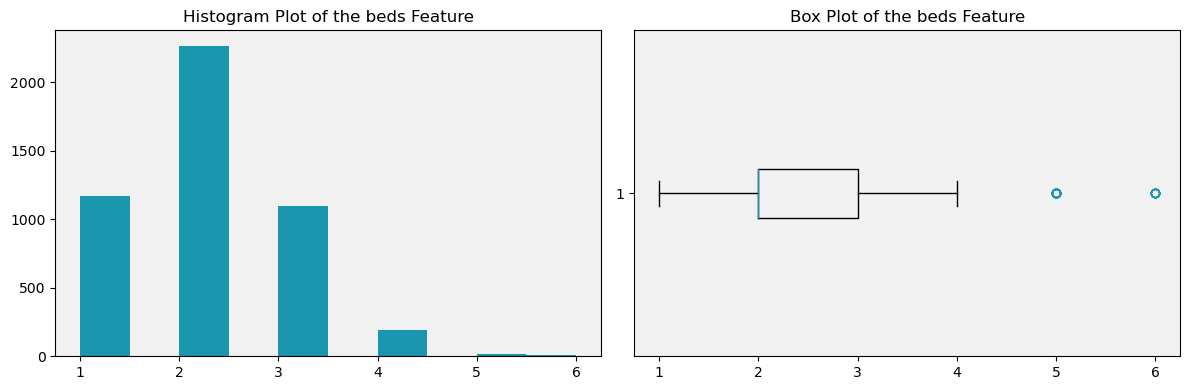

count     4746.000000
mean       396.098924
std        884.104453
min         13.583076
25%        113.192300
50%        181.107680
75%        373.534590
max      39617.305000
Name: price, dtype: float64


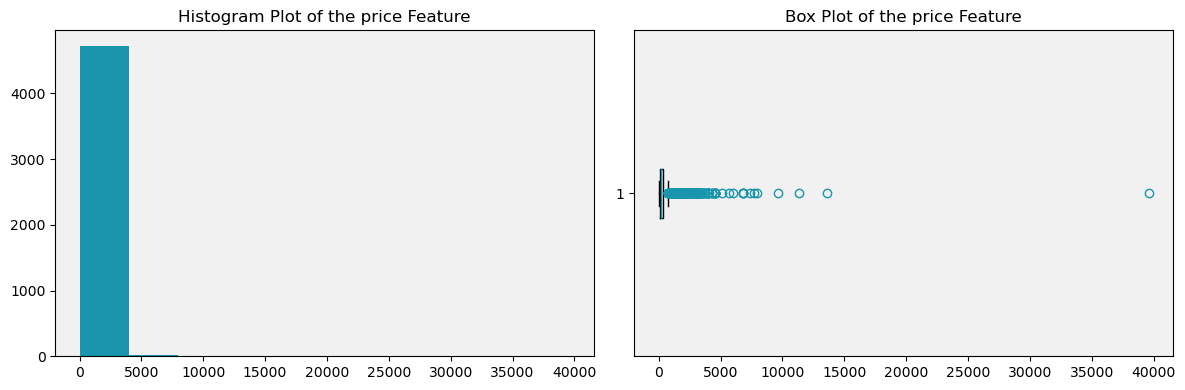

count    4746.000000
mean      967.490729
std       634.202328
min        10.000000
25%       550.000000
50%       850.000000
75%      1200.000000
max      8000.000000
Name: sqfeet, dtype: float64


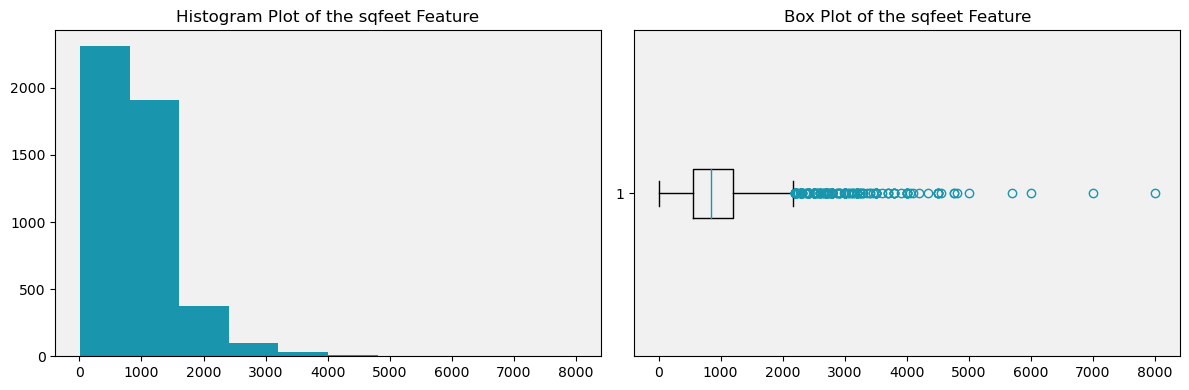

count    4746.000000
mean        0.617573
std         0.486031
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: comes_furnished, dtype: float64


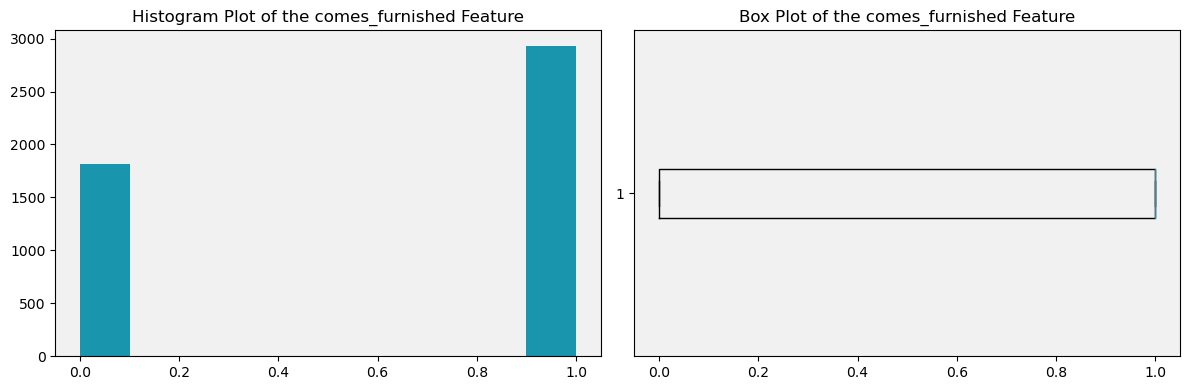

count    4746.000000
mean        1.965866
std         0.884532
min         1.000000
25%         1.000000
50%         2.000000
75%         2.000000
max        10.000000
Name: baths, dtype: float64


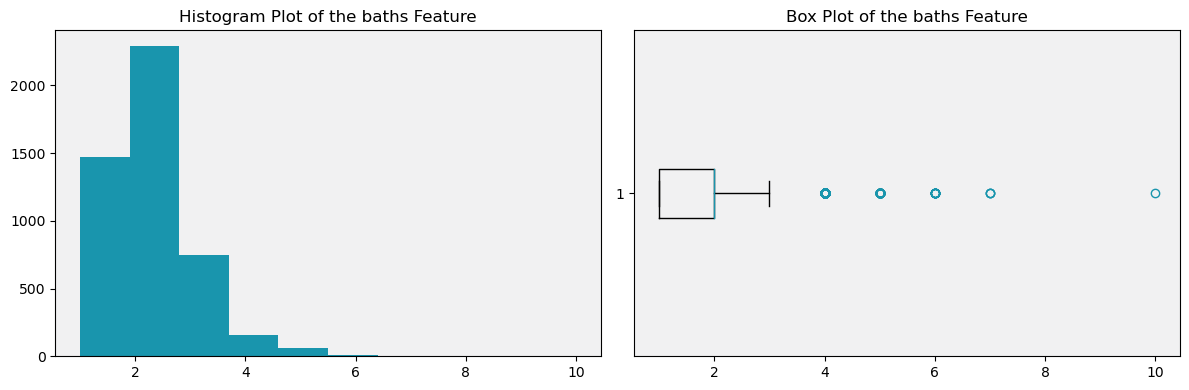

In [72]:
for col in df.columns:
    plot_distribution(df, col)

- price and sqfeet features seem to have outliers

---

### Dropping Outliers

In [73]:
# creating some helper functions to use it in every feature

def find_iqr_and_fences(df, feature):
    iqr = df[feature].quantile(0.75) - df[feature].quantile(0.25)
    upper_fence = df[feature].quantile(0.75) + 1.5 * iqr
    lower_fence = df[feature].quantile(0.25) - 1.5 * iqr
    
    print(f"{feature} feature's IQR: {iqr}")    
    print(f"Samples above with value {upper_fence} should be dropped")
    print(f"Amount of outliers detected in upper region: {df[df[feature] > upper_fence].shape[0]}\n")
    
    print(f"Samples below with value {lower_fence} should be dropped")
    print(f"Amount of outliers detected in lower region: {df[df[feature] < lower_fence].shape[0]}")
    
    return lower_fence, upper_fence
    
def outlier_viz(df, feature):
    print(df[feature].describe())
    
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 8), dpi=80)
    
    gs = ax[0, 0].get_gridspec()
    # # remove the wanted axes
    ax[0, 0].remove()
    ax[0, 1].remove()

    axwide = fig.add_subplot(gs[0, 0:])
    
    axwide.set_facecolor("#f1f1f2")
    axwide.boxplot(df[feature], vert=False, medianprops = dict(color = "#1995ad"),
                   flierprops = dict(markeredgecolor = "#1995ad"))
    axwide.set_title(f"Box Plot of the {feature} feature")
    
    ax[1, 0].set_facecolor("#f1f1f2")
    ax[1, 0].hist(df[feature], color="#1995ad")
    ax[1, 0].set_title(f"Histogram Plot of the {feature} feature")
    
    ax[1, 1].set_facecolor("#f1f1f2")
    ax[1, 1].plot(df[feature].sort_values().reset_index().drop("index", axis=1), ls=":", lw=2, color="#1995ad")
    ax[1, 1].set_title(f"Quantile Like Plot of the {feature} feature");

    plt.tight_layout()
    plt.show()

In [74]:
# size before dropping outliers
w_outliers = df.shape[0]

#### price feature

count     4746.000000
mean       396.098924
std        884.104453
min         13.583076
25%        113.192300
50%        181.107680
75%        373.534590
max      39617.305000
Name: price, dtype: float64


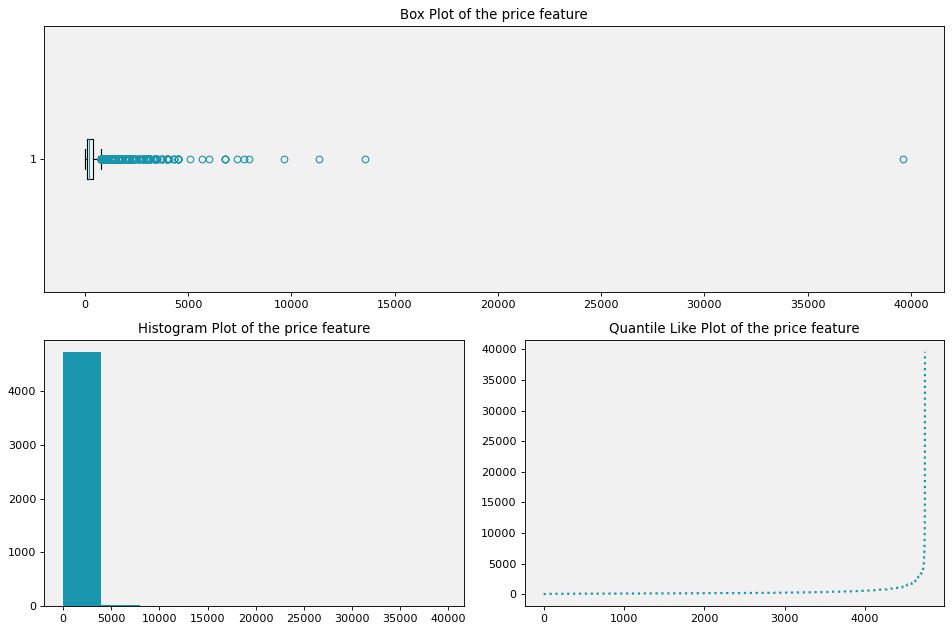

price feature's IQR: 260.34229
Samples above with value 764.0480249999999 should be dropped
Amount of outliers detected in upper region: 520

Samples below with value -277.32113499999997 should be dropped
Amount of outliers detected in lower region: 0
count    4226.000000
mean      218.304510
std       156.492837
min        13.583076
25%       107.532685
50%       169.788450
75%       282.980750
max       758.388410
Name: price, dtype: float64


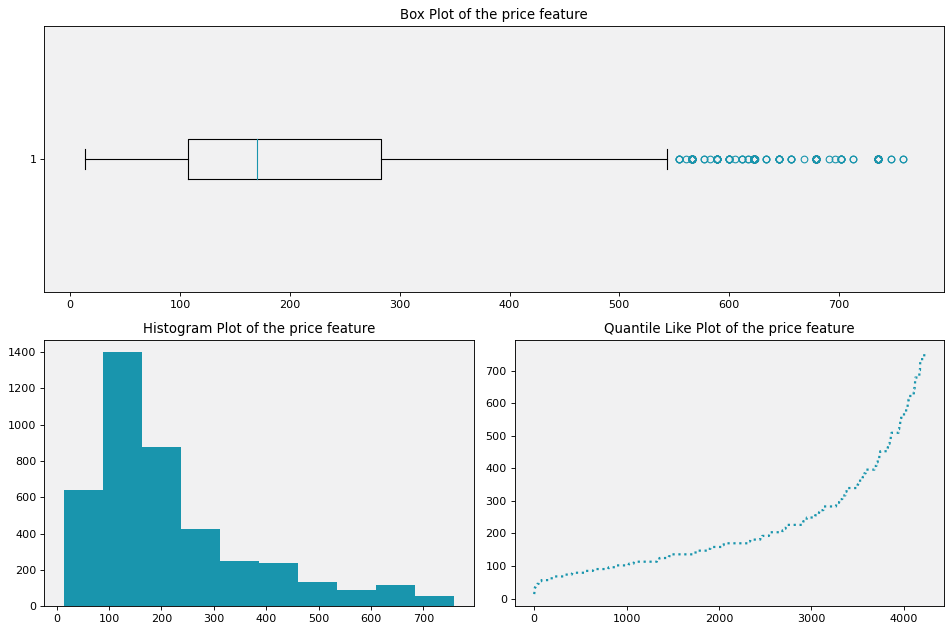

In [75]:
outlier_viz(df, "price")
_, upper = find_iqr_and_fences(df, "price")
# drop outliers
df = df[df["price"] < upper]
# visualize again for checking the difference
outlier_viz(df, "price")

#### sqfeet feature

count    4226.000000
mean      871.779224
std       485.779381
min        10.000000
25%       520.000000
50%       800.000000
75%      1100.000000
max      4200.000000
Name: sqfeet, dtype: float64


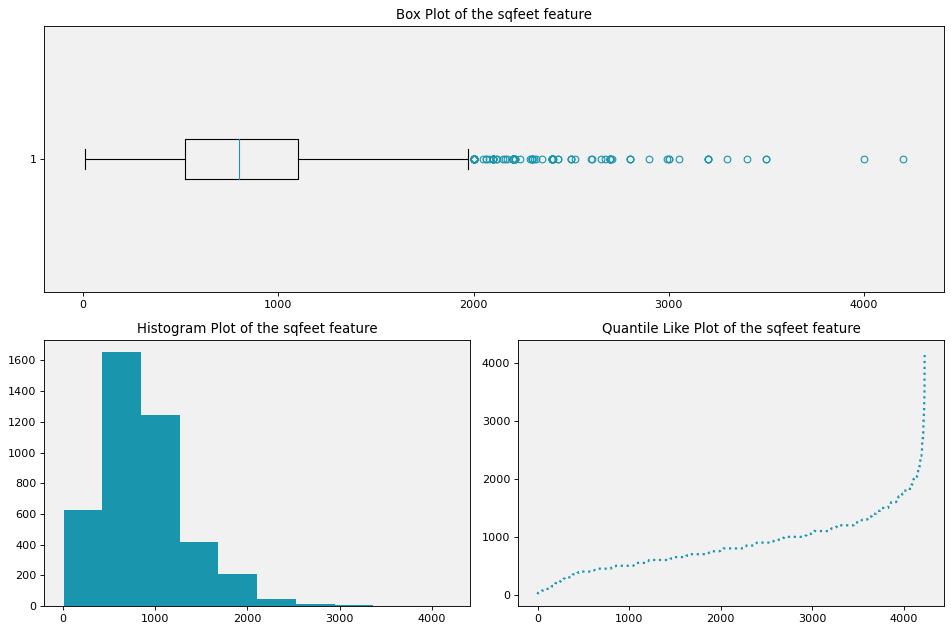

sqfeet feature's IQR: 580.0
Samples above with value 1970.0 should be dropped
Amount of outliers detected in upper region: 123

Samples below with value -350.0 should be dropped
Amount of outliers detected in lower region: 0
count    4102.000000
mean      826.936616
std       410.823218
min        10.000000
25%       500.000000
50%       800.000000
75%      1100.000000
max      1965.000000
Name: sqfeet, dtype: float64


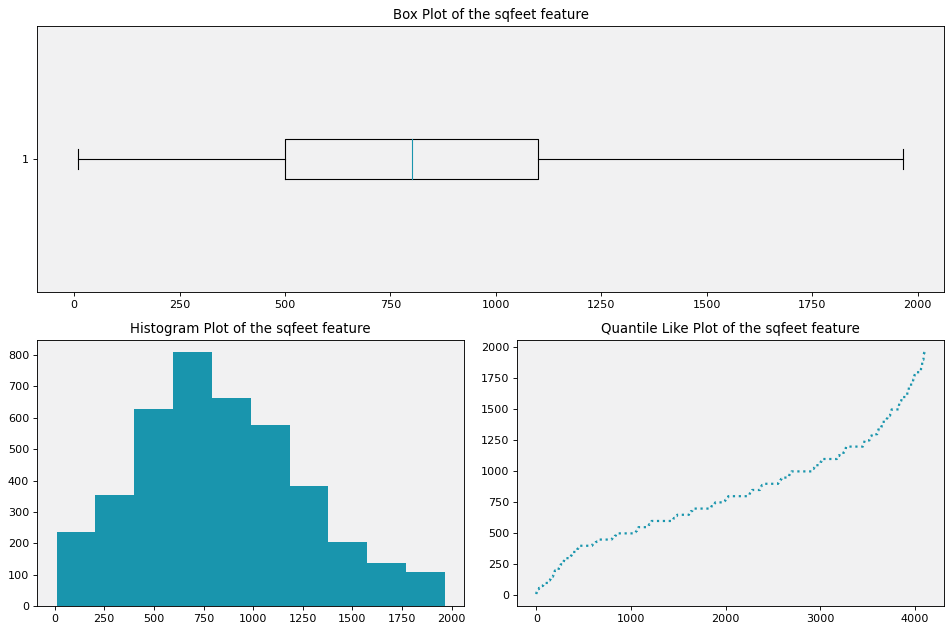

In [76]:
outlier_viz(df, "sqfeet")
_, upper = find_iqr_and_fences(df, "sqfeet")
df = df[df["sqfeet"] < upper]

outlier_viz(df, "sqfeet")

#### beds feature

count    4102.000000
mean        1.921502
std         0.708867
min         1.000000
25%         1.000000
50%         2.000000
75%         2.000000
max         6.000000
Name: beds, dtype: float64


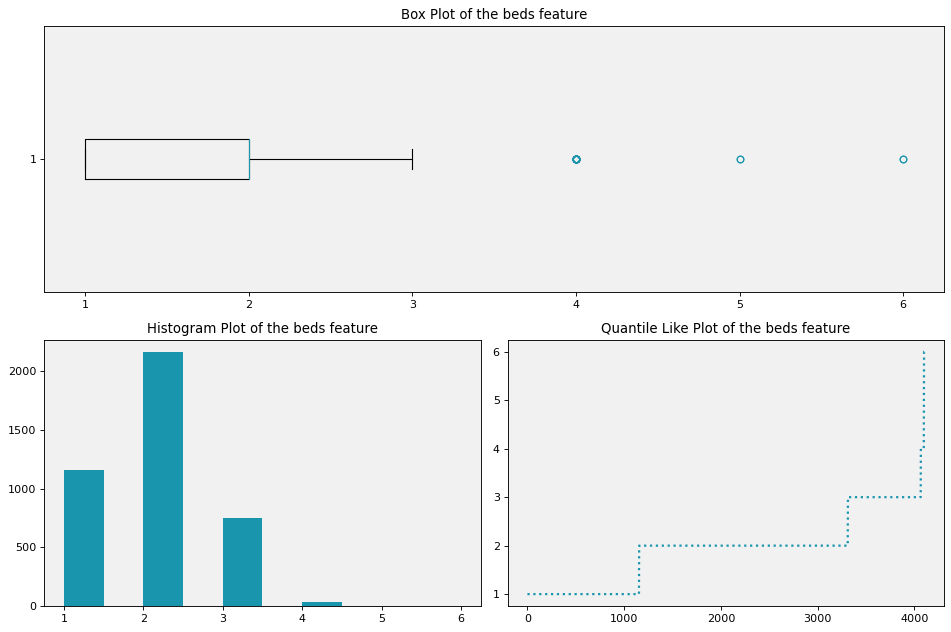

beds feature's IQR: 1.0
Samples above with value 3.5 should be dropped
Amount of outliers detected in upper region: 36

Samples below with value -0.5 should be dropped
Amount of outliers detected in lower region: 0
count    4066.000000
mean        1.901623
std         0.678006
min         1.000000
25%         1.000000
50%         2.000000
75%         2.000000
max         3.000000
Name: beds, dtype: float64


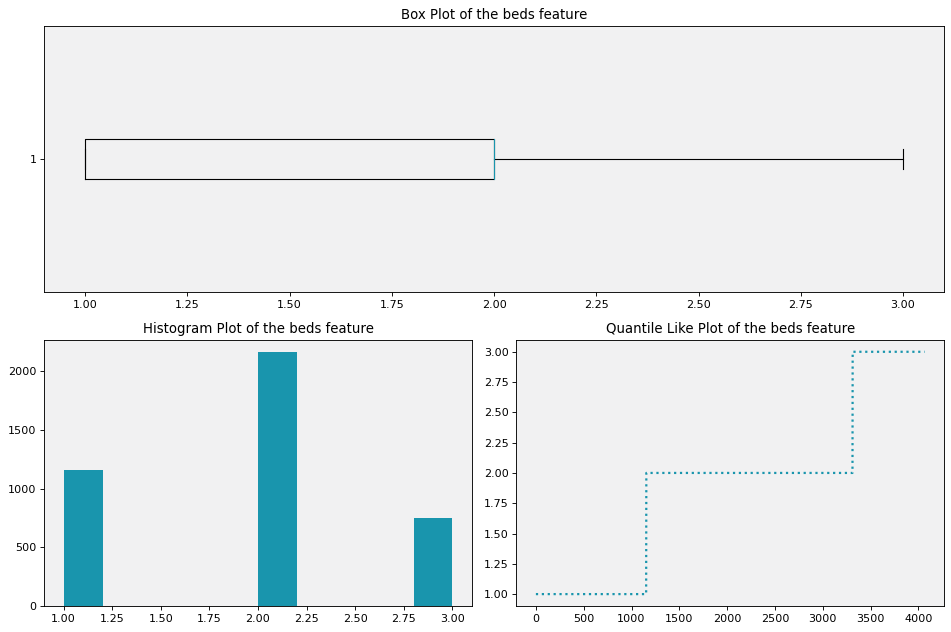

In [77]:
outlier_viz(df, "beds")
_, upper = find_iqr_and_fences(df, "beds")
df = df[df["beds"] < upper]

outlier_viz(df, "beds")

#### baths feature

count    4066.000000
mean        1.756763
std         0.652451
min         1.000000
25%         1.000000
50%         2.000000
75%         2.000000
max         6.000000
Name: baths, dtype: float64


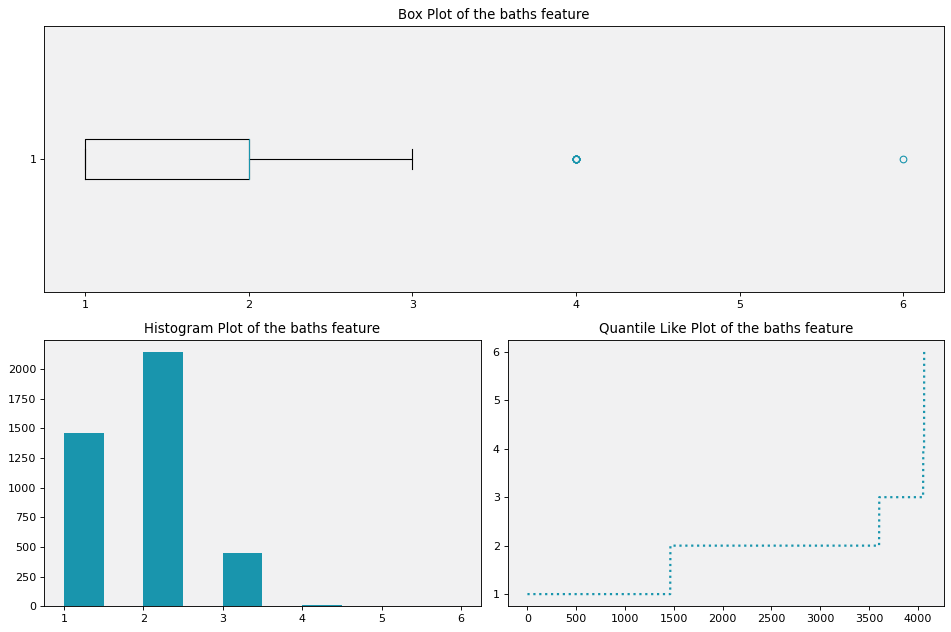

baths feature's IQR: 1.0
Samples above with value 3.5 should be dropped
Amount of outliers detected in upper region: 11

Samples below with value -0.5 should be dropped
Amount of outliers detected in lower region: 0
count    4055.000000
mean        1.750185
std         0.640273
min         1.000000
25%         1.000000
50%         2.000000
75%         2.000000
max         3.000000
Name: baths, dtype: float64


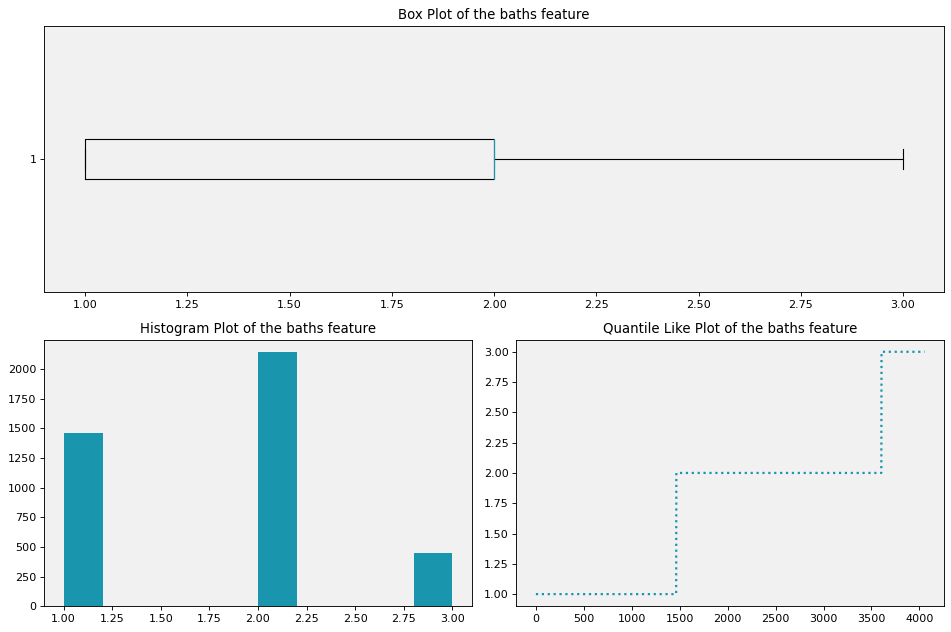

In [78]:
outlier_viz(df, "baths")
_, upper = find_iqr_and_fences(df, "baths")
df = df[df["baths"] < upper]

outlier_viz(df, "baths")

In [79]:
# amount of rows reduced
w_outliers - df.shape[0]

691

# Merging datasets

In [80]:
df.head()

,beds,price,sqfeet,comes_furnished,baths
0,2,113.192300,1100,0,2
1,2,226.384600,800,1,1
2,2,192.426910,1000,1,1
3,2,113.192300,800,0,1
4,2,84.894225,850,0,1


In [81]:
main_dataset = pd.read_csv("main_ordinal_encoded.csv")[df.columns]

main_dataset.head()

,beds,price,sqfeet,comes_furnished,baths
0,3,1120,1319,0,2
1,1,825,1133,0,2
2,1,800,927,0,1
3,2,785,1047,0,1
4,2,900,1298,0,2


In [86]:
df_merged = pd.concat([df, main_dataset])
df_merged = df_merged.reset_index().drop(columns=["index"])
df_merged

,beds,price,sqfeet,comes_furnished,baths
0,2,113.192300,1100,0,2
1,2,226.384600,800,1,1
2,2,192.426910,1000,1,1
3,2,113.192300,800,0,1
4,2,84.894225,850,0,1
...,...,...,...,...,...
194601,2,870.000000,933,0,2
194602,1,929.000000,728,0,1
194603,2,1069.000000,1020,0,2
194604,2,1507.000000,1660,0,2


In [87]:
df_merged.to_csv("merged_dataset.csv", index=False)